In [1]:
%cd ..

d:\iCloudDrive\almas\Knowledge Database\01_DS_ML\02_Machine_Learning\13_Deep_Learning\PyTorch\reviews_classification


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

SEED = 42

In [3]:
df = pd.read_csv('data/reviews.csv')
df.drop(['Unnamed: 0', 'Clothing ID'], axis=1, inplace=True)
df.columns = [c.lower().replace(' ', '_') for c in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   age                      23486 non-null  int64 
 1   title                    19676 non-null  object
 2   review_text              22641 non-null  object
 3   rating                   23486 non-null  int64 
 4   recommended_ind          23486 non-null  int64 
 5   positive_feedback_count  23486 non-null  int64 
 6   division_name            23472 non-null  object
 7   department_name          23472 non-null  object
 8   class_name               23472 non-null  object
dtypes: int64(4), object(5)
memory usage: 1.6+ MB


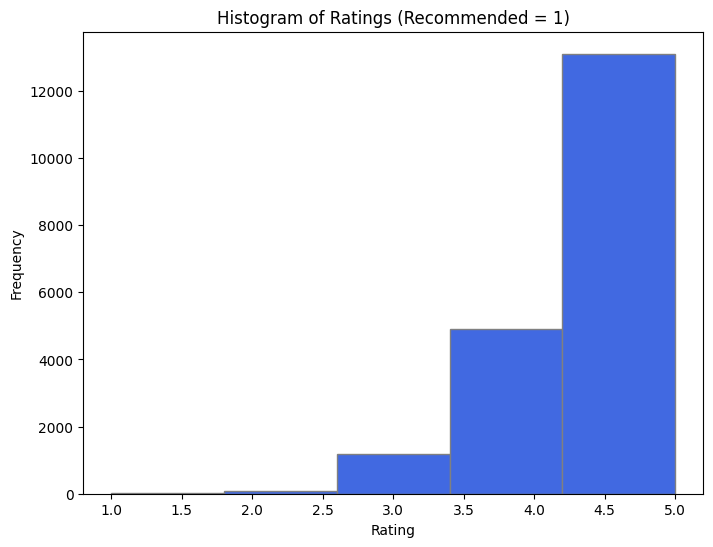

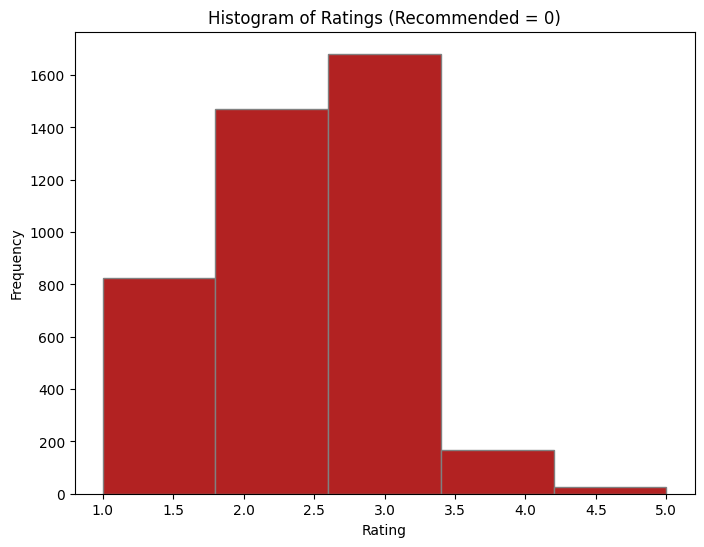

In [4]:
# For recommended_ind == 1
plt.figure(figsize=(8, 6))
plt.hist(df[df['recommended_ind'] == 1]['rating'], bins=5, color='RoyalBlue', edgecolor='gray')
plt.title('Histogram of Ratings (Recommended = 1)')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# For recommended_ind == 0
plt.figure(figsize=(8, 6))
plt.hist(df[df['recommended_ind'] == 0]['rating'], bins=5, color='FireBrick', edgecolor='gray')
plt.title('Histogram of Ratings (Recommended = 0)')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [5]:
df.drop(['recommended_ind'], axis=1, inplace=True)

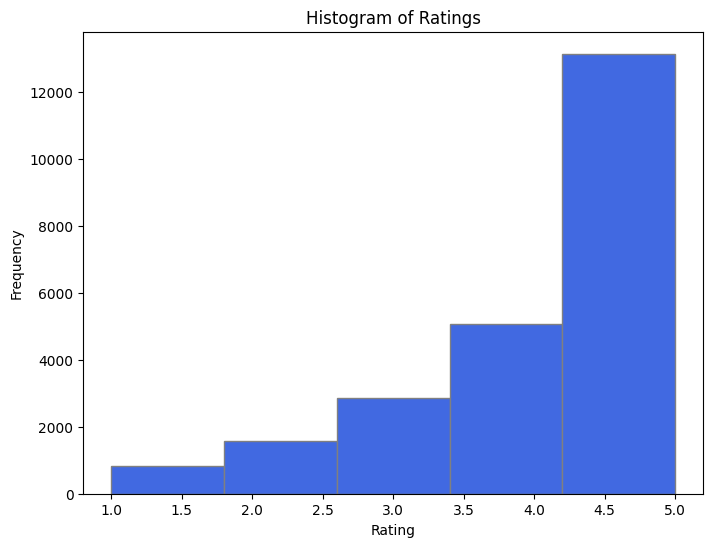

In [6]:
plt.figure(figsize=(8, 6))
plt.hist(df['rating'], bins=5, color='RoyalBlue', edgecolor='gray')
plt.title('Histogram of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [7]:
df['is_positive'] = (df['rating'] > 3).astype(int)
df.drop(['rating'], axis=1, inplace=True)

In [8]:
df['title'] = df['title'].fillna('')
df['review_text'] = df['review_text'].fillna('')
df['review'] = df[['title', 'review_text']].agg('\n'.join, axis=1)
df['review'] = df['review'].replace('', np.nan)
df.drop(['title', 'review_text'], axis=1, inplace=True)

In [9]:
df['review'].str.len().max()

np.int64(557)

In [10]:
df.describe(include=object)

,division_name,department_name,class_name,review
count,23472,23472,23472,23486
unique,3,6,20,22638
top,General,Tops,Dresses,\n
freq,13850,10468,6319,844


In [11]:
df.describe(include=np.number)

,age,positive_feedback_count,is_positive
count,23486.000000,23486.000000,23486.000000
mean,43.198544,2.535936,0.775270
std,12.279544,5.702202,0.417413
min,18.000000,0.000000,0.000000
25%,34.000000,0.000000,1.000000
50%,41.000000,1.000000,1.000000
75%,52.000000,3.000000,1.000000
max,99.000000,122.000000,1.000000


In [12]:
df = df[df['review']!='\n'].copy()

In [13]:
cols_sorted = ['division_name', 'department_name', 'class_name', # 'clothing_id',
       'age', 'positive_feedback_count', 'review', 'is_positive']
df = df[cols_sorted].copy()

In [14]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=SEED)
del df

In [15]:
df_train.isna().sum(), df_test.isna().sum()

(division_name              12
 department_name            12
 class_name                 12
 age                         0
 positive_feedback_count     0
 review                      0
 is_positive                 0
 dtype: int64,
 division_name              1
 department_name            1
 class_name                 1
 age                        0
 positive_feedback_count    0
 review                     0
 is_positive                0
 dtype: int64)

In [16]:
def fill_missing(df, modes):
    df = df.fillna(modes)
    return df

modes_train = df_train.mode().iloc[0]
df_train = fill_missing(df_train, modes_train)
df_test = fill_missing(df_test, modes_train)

In [17]:
df_train.isna().sum(), df_test.isna().sum()

(division_name              0
 department_name            0
 class_name                 0
 age                        0
 positive_feedback_count    0
 review                     0
 is_positive                0
 dtype: int64,
 division_name              0
 department_name            0
 class_name                 0
 age                        0
 positive_feedback_count    0
 review                     0
 is_positive                0
 dtype: int64)

In [18]:
scaler = StandardScaler()
numeric_features = ['age', 'positive_feedback_count']
scaler.fit(df_train[numeric_features])

def scale_nums(df, cols, scaler):    
    # Apply scaling to numeric columns
    df[cols] = scaler.transform(df[cols])
    
    return df

df_train = scale_nums(df_train, numeric_features, scaler)
df_test = scale_nums(df_test, numeric_features, scaler)

In [19]:
categorical_features = ['division_name', 'department_name', 'class_name'] # , 'clothing_id']
encoders = {col: OrdinalEncoder(encoded_missing_value=-1, handle_unknown='use_encoded_value', unknown_value=-1) for col in categorical_features}
for col in categorical_features:
    encoders[col].fit(df_train[[col]])


def prepare_cats(df, encoders):
    for col in encoders.keys():
        df[col] = encoders[col].transform(df[[col]])
    
    return df



df_train = prepare_cats(df_train, encoders)
df_test = prepare_cats(df_test, encoders)

In [20]:
df_train

,division_name,department_name,class_name,age,positive_feedback_count,review,is_positive
12896,1.0,4.0,17.0,0.469411,-0.280787,Soooo soft!\nThis is a delightfully soft and f...,1
13183,1.0,1.0,3.0,-0.343465,-0.449299,"Had my eye on this, but dind't get\nI finally ...",1
1496,0.0,4.0,8.0,0.631986,-0.449299,I wanted to like this...\nI wanted to like thi...,0
5205,0.0,4.0,8.0,1.688725,-0.449299,Beautiful blouse\nBought this for my daughter ...,1
13366,1.0,4.0,8.0,-0.831191,-0.112275,"Boxy. large.\nBoxy, unflattering, and large.\n...",0
...,...,...,...,...,...,...,...
12407,0.0,4.0,8.0,2.257738,0.056237,Good fit\nWas looking for a top with this styl...,1
22386,0.0,4.0,0.0,0.713274,-0.449299,Beautiful!!! runs small\nThis top is gorgeou...,1
5590,0.0,4.0,8.0,-0.912479,-0.449299,Cute tee\nI bought one of these tees and i was...,1
901,0.0,0.0,7.0,-1.075054,-0.280787,Not petite inseam...\nI was excited to see the...,0


In [21]:
df_train[categorical_features] = df_train[categorical_features] + 1
df_test[categorical_features] = df_test[categorical_features] + 1

In [22]:
df_train[categorical_features+numeric_features] = df_train[categorical_features+numeric_features].astype(int)
df_test[categorical_features+numeric_features] = df_test[categorical_features+numeric_features].astype(int)

In [23]:
df_train.shape, df_test.shape

((16981, 7), (5661, 7))

In [24]:
df_train.to_csv('data/train.csv', index=False)
df_test.to_csv('data/test.csv', index=False)

with open('data/categorical_features.pkl', 'wb') as f:
    pickle.dump(categorical_features, f)
with open('data/numeric_features.pkl', 'wb') as f:
    pickle.dump(numeric_features, f)